In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# This is for if we're trying to execute on a remote JupyterHub, where the pwd is set to the server root, or else I think pwd is set correctly already.
# %cd CD_Circuit/

import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools
import operator

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals, compare_same
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.ioi_dataset import IOIDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model
from pyfunctions.wrappers import Node, AblationSet

## Load Model

Note: Unlike with the BERT model + medical dataset objective, it is not necessary to pretrain GPT-2 to perform the IOI dataset.
GPT-2-small is already capable of performing IOI; that's part of the point of the Mech Interp in the Wild paper.
We only need to examine how it does it.

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.
# This makes some sense, since EasyTransformer, the repo/lib released by the IOI guys, was forked from TransformerLens.
# In fact, this makes the reproduction a little bit more faithful, since they most likely do certain things such as 
# "folding" LayerNorms to improve their interpretability results, and we are able to do the same by using TransformerLens.
# HuggingFace, by contrast, has the most impenetrable docs and tons of outdated APIs and etc.; even their source 
# code is impossible to traverse, and I gave up on it, thankfully quickly.

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)
                                          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loaded pretrained model gpt2-small into HookedTransformer


## Generate mean activations

This is not as simple as it sounds; for the IOI paper, for each individual input following a template, they ablate using the mean activations of the "ABC" dataset, generated over sentences following the same template.

In [4]:
from pyfunctions.ioi_dataset import IOIDataset

# Generate a dataset all consisting of one template, randomly chosen.
# nb_templates = 2 due to some logic internal to IOIDataset:
# essentially, the nouns can be an ABBA or ABAB order and that counts as separate templates.
ioi_dataset = IOIDataset(prompt_type="mixed", N=3, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension

attention_outputs = [cache['blocks.' + str(i) + '.hook_attn_out'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, head, seq, d_model
mean_acts = torch.mean(attention_outputs, dim=0)
mean_acts.shape

2024-09-02 22:28:04.347444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 22:28:05.885720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([12, 16, 768])

In [5]:

# source_list = [Node(0, 0, 0), Node(1, 1, 1)]
# target_nodes = [(7, 0, 1)]

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
# out_decomps, target_decomps, _ = prop_GPT(encoding_idxs, extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)

Note it is possible to do the analysis "batchwise" by just taking the mean of the relevance scores (at time of writing, this detail isn't in the paper, I think).

In [23]:
import functools
ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(input_shape[-1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

# print(source_nodes[:64])
target_nodes = [Node(7, 0, 1)]
# target_nodes = []

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
out_decomps, target_decomps = batch_run_new(prop_fn, ablation_sets)

In [24]:
type(out_decomps)
len(out_decomps)

2304

In [25]:
type(target_decomps)
print(len(target_decomps))
print(target_decomps[1])
# target_decomps_0  = sum((x[0] for x in target_decomps), start=TargetNodeDecompositionList((target_nodes[0])))

2304
TargetNodeDecompositionList(ablation_set=(Node(layer_idx=0, sequence_idx=0, attn_head_idx=1),), target_nodes=[Node(layer_idx=7, sequence_idx=0, attn_head_idx=1)], rels=[tensor([[-4.3728e-03, -1.6879e-02,  1.1377e-02, -3.7736e-02, -2.7680e-03,
          1.1830e-02,  2.0415e-02,  4.0660e-02, -6.1969e-02,  1.8279e-02,
          5.5179e-04,  1.1143e-02,  1.8905e-03, -2.2309e-02,  2.4620e-03,
          2.1823e-04, -4.6860e-03,  6.2320e-03, -6.7943e-02,  3.4332e-02,
         -3.0563e-04, -2.8815e-02, -8.9610e-02,  2.0992e-03, -3.9716e-04,
         -5.4938e-02, -9.6853e-03, -5.2798e-02,  4.2523e-03,  1.8252e-02,
         -8.6224e-02, -3.7990e-02, -2.7555e-01, -1.0652e-03, -1.6171e-02,
          1.4562e-03, -5.9614e-02, -1.2768e-02, -2.3432e-03, -5.1467e-02,
         -3.3579e-02, -1.5798e-02,  7.3193e-03,  9.6150e-03,  3.4743e-02,
          2.2641e-02, -3.3099e-02, -8.5741e-02, -1.2671e-02, -9.1949e-02,
          3.2753e-03, -1.5646e-02, -1.3717e-04,  1.7307e-02, -4.5927e-02,
         -5.

In [26]:
# for each source node determine the contribution of rel to the actual score

logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
io_logit = logits[0, -1, ioi_dataset.io_tokenIDs[0]]
s_logit = logits[0, -1, ioi_dataset.s_tokenIDs[0]]
full_score = io_logit - s_logit

results = []
Result = collections.namedtuple('Result', ('source_node', 'score'))

for decomp in out_decomps:
    rel_io_logit = decomp.rel[0, -1, ioi_dataset.io_tokenIDs[0]]
    rel_s_logit = decomp.rel[0, -1, ioi_dataset.s_tokenIDs[0]]
    score = rel_io_logit - rel_s_logit
    #print(score, rel_io_logit, rel_s_logit)
    norm_score = score / full_score
    results.append(Result(decomp.source_node, norm_score))


0.22385299 0.7221562 0.49830323
0.2392534 0.76870185 0.52944845
0.23667926 0.7733195 0.5366402
0.23685014 0.7638366 0.5269865
0.23639035 0.7733022 0.53691185
0.22272491 0.7186734 0.4959485
0.22582316 0.7341071 0.5082839
0.2316314 0.7488418 0.5172104
0.22642213 0.7246672 0.49824506
0.23495615 0.7564904 0.52153426
0.23141754 0.75336504 0.5219475
0.22926027 0.75442255 0.5251623
0.24723536 0.7557521 0.5085167
0.25159848 0.7492246 0.49762613
0.24483094 0.71617734 0.4713464
0.24234149 0.70445 0.46210852
0.24467531 0.7139339 0.46925858
0.25080615 0.7614866 0.51068044
0.25057125 0.73540264 0.4848314
0.2454082 0.6988676 0.4534594
0.24986425 0.73636264 0.4864984
0.24615115 0.71148944 0.4653383
0.24714243 0.72087544 0.473733
0.25133368 0.7378857 0.48655203
0.31205982 0.8644854 0.55242556
0.2823128 0.8421648 0.559852
0.31745702 0.8692186 0.55176157
0.33402258 0.9390005 0.6049779
0.36480993 0.9478487 0.58303875
0.31658602 0.89182043 0.5752344
0.306787 0.854296 0.547509
0.30229092 0.85053474 0.54824

In [8]:
source_list = [(11, 0, 0)]
out_decomps, target_decomps, _ = prop_GPT(ioi_dataset.toks[0:1, :], extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)
rel1 = out_decomps[0].rel

source_list = [(11, 0, 1)]
out_decomps, target_decomps, _ = prop_GPT(ioi_dataset.toks[0:1, :], extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)
rel2 = out_decomps[0].rel

#print(rel1)


set rel/irrel for source node, batch_idx  (11, 0, 0) [0]
mean act was:  tensor([ 4.3381,  4.3175,  4.1953,  4.4962,  4.3581,  4.2597,  4.5472,  4.5256,
         4.5398,  4.3996,  4.3893,  4.1143,  4.2761,  4.4938,  4.2828,  4.2813,
         4.4125,  4.5117,  4.5224,  4.2365,  4.2461,  4.3754,  4.4378,  4.4196,
         4.1841,  4.3478,  4.4578,  4.5042,  4.5110,  4.8423,  4.3440,  4.4366,
         4.2189,  4.1272,  4.1817,  4.2968, 22.1240,  4.5640,  4.4600,  4.4444,
         4.3637,  4.3948,  4.7283,  4.2437,  4.2377,  4.0271,  4.3663,  4.4075,
         4.3571,  4.1481,  4.5351,  4.2055,  4.0362,  4.3295,  4.5534,  3.9828,
         4.3085,  4.5576,  4.2134,  4.4471,  3.9249,  4.4140,  4.6684,  4.2879],
       device='cuda:0')
set rel/irrel for source node, batch_idx  (11, 0, 1) [0]
mean act was:  tensor([-50.4150,   4.5419,   4.0771,   4.4587,   4.3852,   4.3702,   4.7570,
          4.1151,   4.4245,   4.5867,   4.2426,   4.3015,   4.5942,   4.2429,
          3.9775,   4.2670,   4.311

In [27]:

results.sort(key=operator.attrgetter('score'), reverse=True)

In [78]:
results

[Result(source_node=(11, 15, 2), score=0.026049923),
 Result(source_node=(11, 15, 1), score=0.022229344),
 Result(source_node=(11, 15, 10), score=0.010748272),
 Result(source_node=(11, 15, 11), score=0.009650529),
 Result(source_node=(11, 15, 5), score=0.009105967),
 Result(source_node=(11, 15, 8), score=0.008731268),
 Result(source_node=(11, 15, 9), score=0.0045712376),
 Result(source_node=(11, 15, 6), score=0.003845009),
 Result(source_node=(11, 15, 4), score=0.0032666253),
 Result(source_node=(11, 15, 3), score=0.0023612017),
 Result(source_node=(11, 0, 0), score=0.0),
 Result(source_node=(11, 0, 1), score=0.0),
 Result(source_node=(11, 0, 2), score=0.0),
 Result(source_node=(11, 0, 3), score=0.0),
 Result(source_node=(11, 0, 4), score=0.0),
 Result(source_node=(11, 0, 5), score=0.0),
 Result(source_node=(11, 0, 6), score=0.0),
 Result(source_node=(11, 0, 7), score=0.0),
 Result(source_node=(11, 0, 8), score=0.0),
 Result(source_node=(11, 0, 9), score=0.0),
 Result(source_node=(11, 

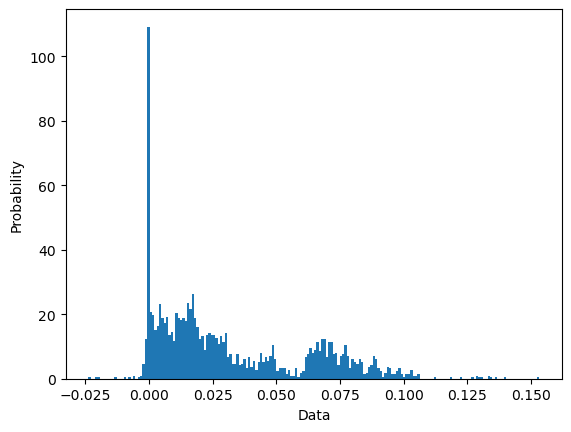

In [28]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = [result.score for result in results]
np.random.seed(42)

plt.hist(scores, density=True, bins=192)  # density=False would make counts
plt.ylabel('Density')
plt.xlabel('Contribution')

In [29]:
import bisect
def interquartile_range(results, iqr_multiplier=1):
    # assume sorted in increasing order
    third_quartile = results[int(len(results) * 0.75)].score
    first_quartile = results[int(len(results) * 0.25)].score
    IQR = third_quartile - first_quartile
    outlier_score = third_quartile + iqr_multiplier * IQR
    print(third_quartile, first_quartile, outlier_score)

    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

In [30]:
def n_sigma_rule(results, n=3):
    scores = [r.score for r in results]
    std_dev = np.std(scores)
    mean = np.mean(scores)
    outlier_score = mean + std_dev * n
    print(std_dev, mean, outlier_score)
    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):] #bisect does a binary search, returns idx of outlier_score
    return outliers

In [37]:
results.sort(key=operator.attrgetter('score'), reverse=False)
iqr = interquartile_range(results)
print(len(iqr))
outliers = n_sigma_rule(results, n=3)
print(len(outliers))

0.056104362 0.0071276473 0.10508107766509056
18
0.03002767 0.031796653 0.12187966518104076
12


# One more iteration: Find maximally relevant source nodes to target nodes

In [79]:
# cache activations for later

# Note: I discovered that the calculation of rels is very sensitive to the cached pre-layer activations
# Since the forward pass via TransformerLens is very slightly different for numerical reasons, this is enough to throw off the calculation of rels substantially
# logits, cache = model.run_with_cache(ioi_dataset.toks[0])
# pre_layer_activations = [cache['blocks.' + str(i) + '.hook_resid_pre'] for i in range(12)]
_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

In [81]:
target_nodes = [r.source_node for r in outliers]
ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(input_shape[-1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
out_decomps, target_decomps = batch_run_new(prop_fn, ablation_sets)

In [86]:
print(len(target_nodes))

12


In [89]:
results = []
for target_decomp in target_decomps:
    # this is just the same as what we did on BERT, seems like we take the ratio of the l1 norm of rel to l1 norm of irrel, summed over target nodes
    score = 0
    for i in range(len(target_decomp.target_nodes)):
        rels_magnitude = np.mean(abs(target_decomp.rels[i]))
        if rels_magnitude > 0:
            print('rels has something')
        irrels_magnitude = np.mean(abs(target_decomp.irrels[i]))
        target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
        score += target_node_score
    results.append(Result(target_decomp.ablation_set[0], score))

In [90]:
results.sort(key=operator.attrgetter('score'), reverse=True)
results

[Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=0), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=1), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=2), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=3), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=4), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=5), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=6), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=7), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=8), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=9), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=10), score=0),
 Result(source_node=Node(layer_idx=0, sequence_idx=0, attn_head_idx=11), score=0),
 Result(source